In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subho117/fake-news-detection-using-machine-learning")

print("Path to dataset files:", path)

d:\src_git\learn_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 41.0M/41.0M [00:04<00:00, 9.70MB/s]

Extracting files...


Path to dataset files: C:\Users\kumar\.cache\kagglehub\datasets\subho117\fake-news-detection-using-machine-learning\versions\1


In [2]:
# library imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("C:\\Users\\kumar\\.cache\\kagglehub\\datasets\\subho117\\fake-news-detection-using-machine-learning\\versions\\1\\News.csv", index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Data Preprocessing

In [5]:
data.shape

(44919, 5)

In [ ]:
data = data.drop(['title', 'subject', 'date'], axis=1)  # Dropping the unwanted columns as part of preprocessing.

In [7]:
data.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [ ]:
data.isnull().sum()  # 0's are good.

text     0
class    0
dtype: int64

In [9]:
# We will shuffle the dataset to avoid bias and then we will reset the index and then drop it as it is of no use to us

# Shuffling

data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

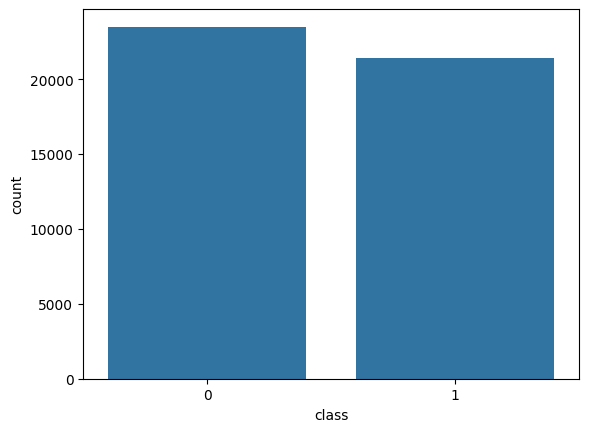

In [10]:
# Exploring the unique values in each category
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)